#«Определение расстояния до впереди идущего автомобиля на основе изображений»

Задача в рамках чемпионата "Цифровой прорыв 2022"

**Условие задачи**

Перед участниками чемпионата стоит задача — разработать алгоритм, позволяющий определить дистанцию до впереди идущего автомобиля, используя для этого датасет фотографий автомобилей с разного расстояния. Впоследствии этот алгоритм может быть использован в системах навигации для предупреждения об опасном сближении и для контроля за соблюдением дистанции.


**Описание входных значений**

train – набор изображений с автомобилями

train.csv – для каждого изображения из train по названию файла определено расстояние для автомобиля

test – набор изображений, для которых необходимо определить целевое значение

# Решение задачи

##Установка и импорт модулей

In [65]:
!pip install pyheif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import pandas as pd
import os
from PIL import Image
import pyheif
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import cv2
import numpy as np
import imutils
import random
from tqdm import tqdm

%matplotlib inline

##Подготовка данных

Скачиваем данные

In [265]:
train_labels_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/train_dataset_train/train.csv', sep=';')

In [68]:
train_labels_pd

,image_name,distance
0,img_1596.jpg,4.88
1,img_1600.jpg,1.54
2,img_1601.jpg,3.68
3,img_1603.jpg,2.22
4,img_1605.jpg,3.73
...,...,...
525,img_2939.jpg,3.00
526,img_2940.jpg,3.46
527,img_2941.jpg,3.91
528,img_2944.jpg,5.20


In [ ]:
train_labels_pd.sort_values('distance')

,image_name,distance
480,img_2858.jpg,0.85
124,img_1841.jpg,1.06
479,img_2857.jpg,1.09
19,img_1628.jpg,1.12
199,img_2001.jpg,1.16
...,...,...
368,img_2581.jpg,8.74
90,img_2723.heic,8.78
80,img_2696.heic,8.80
260,img_2333.jpg,9.06


Посмотрим, какие значения принимает distance, все ли они корректные.

In [ ]:
#нет ли Nan
train_labels_pd.distance.isna().sum()

0

In [ ]:
train_labels_pd.distance.describe()

count    530.000000
mean       4.181038
std        1.758791
min        0.850000
25%        2.812500
50%        4.010000
75%        5.407500
max        9.380000
Name: distance, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


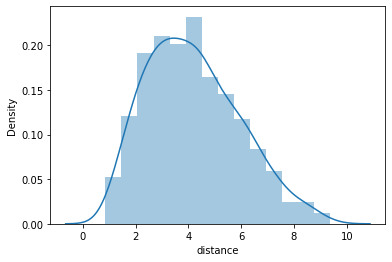

In [ ]:
ax = sns.distplot(train_labels_pd.distance)

В тренировочном датасете всего 530 изображений, distance принимает значения от 0.85 до 9.38.

In [266]:
train_path='/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/train_dataset_train/train'
train_img_names = os.listdir(train_path)

In [ ]:
len(train_img_names)

530

In [ ]:
set(train_img_names) == set(train_labels_pd.image_name)

True

Кол-во изображений в папке и scv файле совпадает. Их имена тоже.

Посмотрим, как выглядят изображения из тренировочного датасета

In [70]:
def open_img(path, name):
  if 'heic' in name:
      heif_file = pyheif.read(os.path.join(path, name))
      img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
      img = Image.open(os.path.join(path, name))
  return img

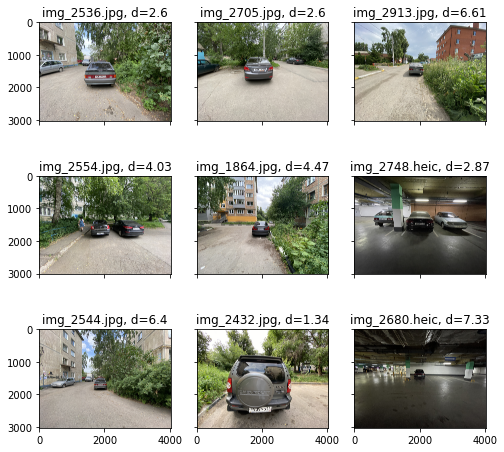

In [ ]:
def show_picts():
  fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
  for fig_x in ax.flatten():
      random_name = random.choice(train_labels_pd.image_name)
      random_img = open_img(train_path, random_name)
      img_label = float(train_labels_pd[train_labels_pd.image_name == random_name].distance)
      fig_x.imshow(random_img)
      fig_x.set_title(random_name + ', d=' + str(img_label))
      fig_x.grid(False)

show_picts()

Видно, что в на фото может присутствовать несколько автомобилей, будем полагать, что расстояние измеряется до центрального авто.

## Извлечение метаданных для изображений.



Соберем информацию из exif изображений в датафрейм

Jpg:

In [314]:
from PIL.ExifTags import TAGS
#словарь TAGS отображает каждый идентификатор в текст

In [315]:
def get_exif(img):
  exifdata = img.getexif()
  exif_info = []
  for tag_id in exifdata:
      data = exifdata.get(tag_id)
      exif_info.append(data)
  return exif_info

In [326]:
def get_tags():
  img = open_img(train_path, 'img_2544.jpg')
  exifdata = img.getexif()
  tags = []
  for tag_id in exifdata:
      # получить имя тега вместо идентификатора
      tag = TAGS.get(tag_id, tag_id)
      tags.append(tag)
  return tags

heic:

In [74]:
!pip3 install exifread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [317]:
import io
import exifread

def get_heic_exif(heif_file):
  img_metadata = heif_file.metadata

  for metadata in img_metadata:
    if metadata['type']=='Exif':
        fstream = io.BytesIO(metadata['data'][6:])

  return exifread.process_file(fstream)

In [318]:
def get_keys(name, tags):
  keys = []
  for key in tags.keys():
    keys.append(str(key))
  return keys

def get_values(tags):
  values = []
  for value in tags.values():
    values.append(str(value))
  return values

Соберем датафреймы с jpg и heic файлов:

In [319]:
exif_info = {} #jpg
exif_heic_info = {} #heic
keys = []

for name in tqdm(train_labels_pd.image_name):
  if 'heic' in name:
    heif_file = pyheif.read(os.path.join(train_path, name))
    tags = get_heic_exif(heif_file) #type dict
    if len(keys) < len(get_keys(name, tags)):
      keys = get_keys(name, tags) # список используемых колонок для heic
    exif_heic_info[name] = get_values(tags)

  else:
    img = open_img(train_path, name)
    exif_info[name] = get_exif(img)

exif_heic_info_df = pd.DataFrame.from_dict(exif_heic_info, orient='index', columns=keys)
tags = get_tags() # список используемых колонок для jpg
exif_info_df = pd.DataFrame.from_dict(exif_info, orient='index', columns=tags)

100%|██████████| 530/530 [00:23<00:00, 22.43it/s] 


Выберем интересующие нас колонки в jpg dataframe

In [78]:
exif_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, img_1596.jpg to img_2945.jpg
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ExifVersion              482 non-null    object
 1   ComponentsConfiguration  482 non-null    object
 2   ShutterSpeedValue        482 non-null    object
 3   DateTimeOriginal         482 non-null    object
 4   DateTimeDigitized        482 non-null    object
 5   ApertureValue            482 non-null    object
 6   BrightnessValue          482 non-null    object
 7   ExposureBiasValue        482 non-null    object
 8   MeteringMode             482 non-null    int64 
 9   Flash                    482 non-null    int64 
 10  FocalLength              482 non-null    object
 11  ColorSpace               482 non-null    int64 
 12  ExifImageWidth           482 non-null    int64 
 13  DigitalZoomRatio         482 non-null    object
 14  FocalLengthIn35mmFilm    48

Нас интересует Digital Zoom Ratio, чтобы учитывать пространственные искажения авто на картинке.

In [80]:
exif_info_df = exif_info_df['DigitalZoomRatio']

Выберем интересующие нас колонки в heic dataframe

In [81]:
exif_heic_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, img_2672.heic to img_2756.heic
Data columns (total 100 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Image Make                  48 non-null     object
 1   Image Model                 48 non-null     object
 2   Image Orientation           48 non-null     object
 3   Image XResolution           48 non-null     object
 4   Image YResolution           48 non-null     object
 5   Image ResolutionUnit        48 non-null     object
 6   Image Software              48 non-null     object
 7   Image DateTime              48 non-null     object
 8   Image HostComputer          48 non-null     object
 9   Image TileWidth             48 non-null     object
 10  Image TileLength            48 non-null     object
 11  Image ExifOffset            48 non-null     object
 12  GPS GPSLatitudeRef          48 non-null     object
 13  GPS GPSLatitude             48 no

In [82]:
exif_heic_info_df['EXIF DigitalZoomRatio'].value_counts()

63/61    36
14       12
Name: EXIF DigitalZoomRatio, dtype: int64

In [83]:
exif_heic_info_df = exif_heic_info_df['EXIF DigitalZoomRatio']
exif_heic_info_df = exif_heic_info_df.rename('DigitalZoomRatio')

In [84]:
exif_heic_info_df.head()

img_2672.heic       14
img_2673.heic    63/61
img_2675.heic    63/61
img_2676.heic    63/61
img_2678.heic    63/61
Name: DigitalZoomRatio, dtype: object

Объединим инфо в одну табличку

In [85]:
info_df = pd.concat([exif_info_df, exif_heic_info_df], axis=0)

In [86]:
info_df

img_1596.jpg       (216, 175)
img_1600.jpg     (1512, 1199)
img_1601.jpg     (1512, 1199)
img_1603.jpg     (1512, 1199)
img_1605.jpg     (1512, 1175)
                     ...     
img_2748.heic              14
img_2749.heic           63/61
img_2751.heic           63/61
img_2754.heic           63/61
img_2756.heic           63/61
Name: DigitalZoomRatio, Length: 530, dtype: object

Преобразуем отношение в одно число.

In [87]:
def get_ratio(a):
  numbers = []
  if '/' in a:
    elements = str.split(a, sep='/')
  else:
    elements = str.split(a)
  for el in elements:
    number = str()
    for char in el:
      if char.isdigit():
        number += char
    numbers.append(int(number))
  if len(numbers) == 0:
    return 0
  if len(numbers) == 1:
    return numbers[0]
  if len(numbers) >= 2:
    return numbers[0] / numbers[1]

In [88]:
for index in info_df.index:
  el = str(info_df[index])
  info_df.loc[index] = get_ratio(el)
info_df

img_1596.jpg     1.234286
img_1600.jpg     1.261051
img_1601.jpg     1.261051
img_1603.jpg     1.261051
img_1605.jpg     1.286809
                   ...   
img_2748.heic          14
img_2749.heic    1.032787
img_2751.heic    1.032787
img_2754.heic    1.032787
img_2756.heic    1.032787
Name: DigitalZoomRatio, Length: 530, dtype: object

In [89]:
info_df.unique()

array([1.2342857142857142, 1.261050875729775, 1.2868085106382978, 1.305699481865285, 1.2383292383292384, 26, 1.2352941176470589, 1.3795620437956204, 1.237315875613748, 1.0223123732251522, 1.0595655220742817, 14, 1.0327868852459017], dtype=object)

##Поиск автомобиля на фото.

Распознаем все автомобили на фото с помощью YOLOv5 в конфигурации yolov5x, как самую точную модель, верно определяющую большинство авто.

In [90]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x')
model.classes = [2]  # car

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-26 Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


**Подготовка изображений для Yolo**

Обрежем изображение до квадрата и уменьшим до (640, 640)

In [91]:
# img -> [640,640]
def resize_img(path, img_name):
  img = open_img(path, img_name)
  #crop img to square
  width, height = img.size   # Get dimensions
  a = min(width, height)
  left = (width - a)/2
  top = (height - a)/2
  right = (width + a)/2
  bottom = (height + a)/2
  # Crop the center of the image
  small_img = img.crop((left, top, right, bottom))
  
  #modifies the image, no larger than the given size
  small_img.thumbnail((640, 640), Image.ANTIALIAS)
  return small_img, img

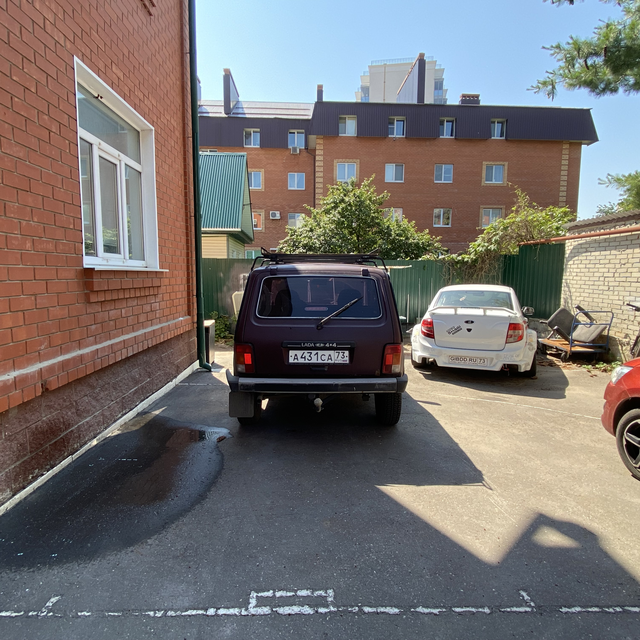

In [92]:
small_img, original_img = resize_img(train_path, 'img_1601.jpg') #img_2645.jpg
small_img

**Выбор центрального авто**

По условиям задачи, мы определяем дистанцию до 1 авто.

Выберем из найденных автомобилей один, который расположен ближе всего к центру фото, с учетом того, что он должен быть больше ближайших соседей

Получим картинку этого авто с оригинального изображения в хорошем качестве.

In [93]:
def find_central_car(small_img, original_img):
  
  #выберем 2 центральных авто
  def best_central_box(small_img, results, confidence):
    a, _ = small_img.size #width, height of squar, = 640
    c_dist = [] # расстояние между центром кадра и центром найденного авто    
    
    #loop for all cars in img
    for box in results.xyxy[0]:
      #print(box)
      # рассматриваем авто только если уверенность модели > confidence
      if box[4] > confidence:
        x1, y1, x2, y2 = np.array(box[:4]).astype(int)
        # сохраним расстояния от центра бокса авто до центра img 
        c_dist.append(abs((x1 + x2) * 0.5 - a / 2))

    # вернем индексы ближайших к центру авто
    sort_index = np.argsort(c_dist)
    
    #если не нашли, выходим из функции
    if len(sort_index) == 0:
      return [None, None, None, None]

    central_boxes = []
    x_c = []
    heights = []

    for i in range(len(sort_index)):
      #координаты авто
      central_boxes.append(np.array(results.xyxy[0][sort_index[i]][:4]).astype(int))
      x_c.append(c_dist[sort_index[i]]) # центр авто
      heights.append(central_boxes[i][3] - central_boxes[i][1])

    #если только 1 central_box, возвращаем его
    if len(sort_index) == 1:
      return central_boxes[0]
  
    #если нашли несколько boxes
    #рассмотрим 3
    #Если между ними и gервым авто небольшое расстояние, то берем то авто, высота которого больше
    for i in range(1, min(len(sort_index), 3)):
    #print('dist', abs(x_c[i] - x_c[i+1]))
      if abs(x_c[i] - x_c[0]) < 100: #150
        if (heights[i]) > (heights[0]):
          return central_boxes[i]
    #Если большое расстояние, то берем центральное авто
    return central_boxes[0]

  # найдем соответствие между координатами crop_image и original_image    
  def return_coordinates(original_img, a, x1, y1, x2, y2):
    w, h = original_img.size
    y1_original, y2_original, x1_original, x2_original = 0, h, 0, w
    #gorisontal oriented img
    if w > h:
      y1_original = int(y1 * h / a)
      y2_original = int(y2 * h / a)
      x1_original = int(x1 * h / a + (w - h) / 2)
      x2_original = int(x2 * h / a + (w - h) / 2)
    #vertical oriented img
    else:
      y1_original = int(y1 * h / a + (h - w) / 2)
      y2_original = int(y2 * h / a + (h - w) / 2)
      x1_original = int(x1 * h / a)
      x2_original = int(x2 * h / a)
    return [x1_original, y1_original, x2_original, y2_original]
  
  #apply yolo
  results = model(np.array(small_img))
  #выберем лучшее авто по центру, с уверенностью yolo > 5%
  x1, y1, x2, y2 = best_central_box(small_img, results, 0.05)
  
  #если не нашли, вернем центральную чась original_img
  if x1 == None:
    print('Car did not found')
    w, h = original_img.size
    return np.asarray(original_img), [0, 0, w, h]
  
  #перевод координат из small_img в original_img
  x1_original, y1_original, x2_original, y2_original = return_coordinates(original_img, small_img.size[0], x1, y1, x2, y2)
  
  #img2 = draw_object(original_img, x1_original, y1_original, x2_original, y2_original)
  #plt.imshow(img2)
  crop_img = np.array(original_img)[y1_original:y2_original, x1_original:x2_original]

  return crop_img, [x1_original, y1_original, x2_original, y2_original]

In [94]:
# вспомогательная ф-я для рисовки прямоугольника вокруг выбранного авто
def draw_object(img, x1, y1, x2, y2):
    # rectangle for car
    start = (x1, y1)
    end = (x2, y2)
    color = (0,255,0)
    thickness = 10
    img2 = cv2.rectangle(np.array(img), start, end, color, thickness)
    return img2

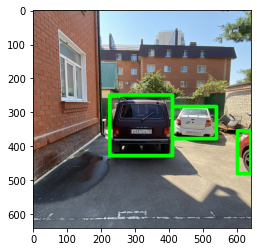

In [95]:
%matplotlib inline
results = model(np.array(small_img))
for box in results.xyxy[0]:
  x1, y1, x2, y2 = np.array(box[:4]).astype(int)
  small_img = draw_object(small_img, x1, y1, x2, y2)
plt.imshow(small_img)

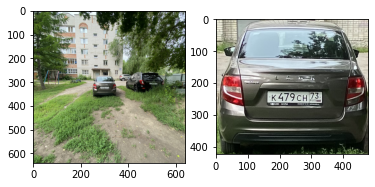

In [96]:
#отбразить исходную уменьшенную картинку и найденное на оригинальном изображении авто
small_img, original_img = resize_img(train_path, 'img_2799.jpg') #img_2645.jpg 2418
crop_img, box = find_central_car(small_img, original_img)
plt.subplot(121)
plt.imshow(small_img)
plt.subplot(122)
plt.imshow(crop_img)

In [ ]:
# сохранить фото с обведенным прямоугольником выбранным авто в папку
img_name = 'img_2026.jpg'
small_img, original_img = resize_img(train_path, img_name) #img_2645.jpg
crop_img, box = find_central_car(small_img, original_img)
img2 = draw_object(original_img, box[0], box[1], box[2], box[3])
save_path='/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/car_detect/'
cv2.imwrite(save_path + img_name, cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

True

##Cоберем датасет для обучения

Мы берем в рассмотрение не только размеры box для машины (width, height), но и его координаты, так как положение машины относительно центра кадра влияет на его пространственные искажения.

In [ ]:
width = {}
height ={}
car_box = {}

for name in tqdm(train_labels_pd.image_name):
  small_img, original_img = resize_img(train_path, name)
  crop_img, box = find_central_car(small_img, original_img)
  width[name] = crop_img.shape[1]
  height[name] = crop_img.shape[0]
  car_box[name] = box
  img2 = draw_object(original_img, box[0], box[1], box[2], box[3])
  save_path='/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/car_detect/'
  cv2.imwrite(save_path + name, cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

  4%|▎         | 19/530 [01:33<40:51,  4.80s/it]

Car did not found


 28%|██▊       | 147/530 [12:07<28:13,  4.42s/it]

Car did not found


 64%|██████▍   | 340/530 [26:40<14:23,  4.54s/it]

Car did not found


 68%|██████▊   | 362/530 [28:21<13:54,  4.97s/it]

Car did not found


100%|██████████| 530/530 [41:08<00:00,  4.66s/it]


In [ ]:
width_df = pd.DataFrame.from_dict(width, orient='index', columns=['width']).reset_index().rename(columns={'index': 'image_name'})
df = train_labels_pd.merge(width_df, on='image_name')
height_df = pd.DataFrame.from_dict(height, orient='index', columns=['height']).reset_index().rename(columns={'index': 'image_name'})
df = df.merge(height_df, on='image_name')
car_box_df = pd.DataFrame.from_dict(car_box, orient='index', columns=['x1', 'y1', 'x2', 'y2']).reset_index().rename(columns={'index': 'image_name'})
df = df.merge(car_box_df, on='image_name')
df.sort_values(by='width')

,image_name,distance,width,height,x1,y1,x2,y2
92,img_2726.heic,8.44,274,232,1831,1417,2105,1649
140,img_1878.jpg,8.41,297,260,1756,1275,2053,1535
80,img_2696.heic,8.80,297,250,1822,1365,2119,1615
260,img_2333.jpg,9.06,302,293,1699,1327,2001,1620
91,img_2724.heic,9.38,312,260,1779,1341,2091,1601
...,...,...,...,...,...,...,...,...
480,img_2858.jpg,0.85,2589,2051,579,618,3168,2669
340,img_2514.jpg,2.50,4032,3024,0,0,4032,3024
362,img_2570.jpg,2.07,4032,3024,0,0,4032,3024
147,img_1890.jpg,1.19,4032,3024,0,0,4032,3024


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/train_dataset_train/car_distance_width_df2.csv')

In [270]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/train_dataset_train/car_distance_width_df2.csv')

Добавим к этим данным Exif info

In [177]:
df = df.set_index('image_name') 
df = pd.concat([df, info_df], axis = 1)

In [178]:
df

,Unnamed: 0,distance,width,height,x1,y1,x2,y2,DigitalZoomRatio
img_1596.jpg,0,4.88,624,543,1656,1176,2280,1719,1.234286
img_1600.jpg,1,1.54,1895,1527,1122,1185,3017,2712,1.261051
img_1601.jpg,2,3.68,869,841,1567,1176,2436,2017,1.261051
img_1603.jpg,3,2.22,1455,1267,1260,1048,2715,2315,1.261051
img_1605.jpg,4,3.73,875,837,1604,1086,2479,1923,1.286809
...,...,...,...,...,...,...,...,...,...
img_2939.jpg,525,3.00,889,756,1500,1067,2389,1823,1.022312
img_2940.jpg,526,3.46,789,671,1576,1039,2365,1710,1.022312
img_2941.jpg,527,3.91,704,605,1529,1209,2233,1814,1.022312
img_2944.jpg,528,5.20,553,482,1557,1242,2110,1724,1.022312


In [179]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/train_dataset_train/all_df.csv')

In [187]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/train_dataset_train/all_df.csv')

Посмотрим на данные и зависимость расстояния до авто от них

In [188]:
df = df.rename(columns={'Unnamed: 0': 'image_name'})
del df['Unnamed: 0.1']

In [189]:
df

,image_name,distance,width,height,x1,y1,x2,y2,DigitalZoomRatio
0,img_1596.jpg,4.88,624,543,1656,1176,2280,1719,1.234286
1,img_1600.jpg,1.54,1895,1527,1122,1185,3017,2712,1.261051
2,img_1601.jpg,3.68,869,841,1567,1176,2436,2017,1.261051
3,img_1603.jpg,2.22,1455,1267,1260,1048,2715,2315,1.261051
4,img_1605.jpg,3.73,875,837,1604,1086,2479,1923,1.286809
...,...,...,...,...,...,...,...,...,...
525,img_2939.jpg,3.00,889,756,1500,1067,2389,1823,1.022312
526,img_2940.jpg,3.46,789,671,1576,1039,2365,1710,1.022312
527,img_2941.jpg,3.91,704,605,1529,1209,2233,1814,1.022312
528,img_2944.jpg,5.20,553,482,1557,1242,2110,1724,1.022312


In [190]:
def plot(df, column_name):
  X = df[column_name].to_numpy()
  y = df.distance.to_numpy()

  plt.figure(figsize=(10, 7))

  plt.scatter(X, y)

  plt.xticks(np.arange(0, 4000, step=500))
  plt.xlabel(column_name)
  plt.ylabel('distance')
  plt.grid(alpha=0.2)
  plt.show()

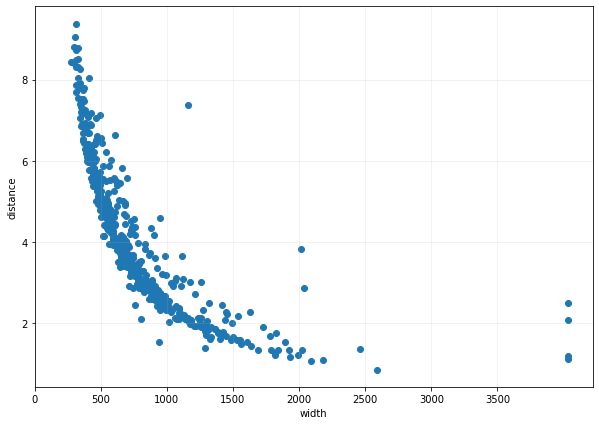

In [191]:
plot(df, 'width')

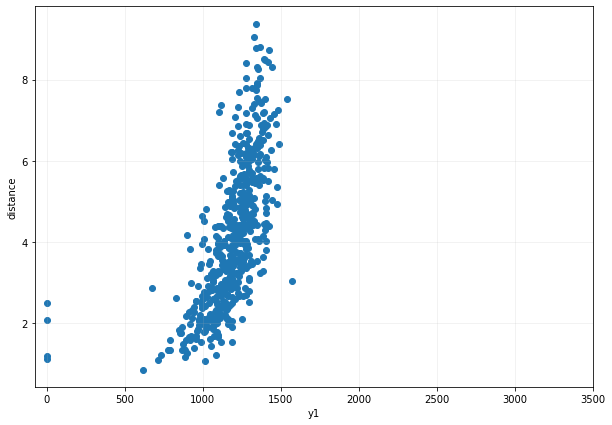

In [192]:
plot(df, 'y1')

Обратим внимание на отдельные точки на графике:

4 автомобиля yolo так и не смогла определить, скорее всего из-за сильных искажений:


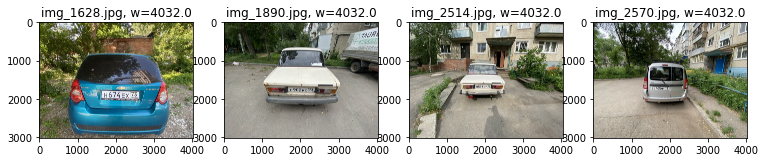

In [193]:
fig = plt.figure(figsize=(16,5))

for i, name in enumerate(df[df.width > 4000].image_name):
  img = open_img(train_path, name)
  img_label = float(df[df.image_name == name].width)
  fig.add_subplot(2,5,i+1)
  plt.imshow(img)
  plt.title(name + ', w=' + str(img_label))

##Модели и предсказания

**Метрика**

Коэффициент детерминации (R2):

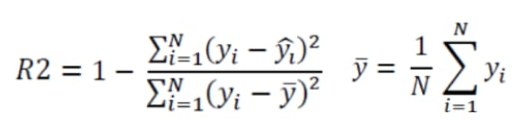

In [276]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Получим предсказания для тестовых данных в зависимости от ширины и высоты авто, его координат и особенностей объектива

In [286]:
test_path='/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/test'
test_img_names = os.listdir(test_path)

In [195]:
# создание датафрейма с параметрами w, h, box для найденных на тестовых изображениях авто
def find_car_test(path, img_names):
  width = {}
  height = {}
  car_box = {}
  for name in tqdm(img_names):
    small_img, original_img = resize_img(path, name)
    crop_img, box = find_central_car(small_img, original_img)
    width[name] = crop_img.shape[1]
    height[name] = crop_img.shape[0]
    car_box[name] = box
  width_df = pd.DataFrame.from_dict(width, orient='index', columns=['width']).reset_index().rename(columns={'index': 'image_name'})
  height_df = pd.DataFrame.from_dict(height, orient='index', columns=['height']).reset_index().rename(columns={'index': 'image_name'})
  car_box_df = pd.DataFrame.from_dict(car_box, orient='index', columns=['x1', 'y1', 'x2', 'y2']).reset_index().rename(columns={'index': 'image_name'})
  df = width_df.merge(height_df, on='image_name')
  df = df.merge(car_box_df, on='image_name')
  return df

Датафрейм с параметрами авто

In [169]:
test_df = find_car_test(test_path, test_img_names)

 22%|██▏       | 116/521 [08:58<30:02,  4.45s/it]

Car did not found


 23%|██▎       | 121/521 [09:20<28:59,  4.35s/it]

Car did not found


 46%|████▌     | 240/521 [17:57<20:26,  4.37s/it]

Car did not found


 71%|███████   | 370/521 [27:28<11:05,  4.40s/it]

Car did not found


 72%|███████▏  | 375/521 [27:50<10:41,  4.39s/it]

Car did not found


 90%|█████████ | 469/521 [34:45<03:44,  4.33s/it]

Car did not found


100%|██████████| 521/521 [38:32<00:00,  4.44s/it]


In [170]:
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/test_df3.csv')

In [287]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/test_df3.csv')

In [121]:
#собрать dataframe c инфо о позиции авто и exif данные
def get_info_df(df):
  exif_info = {} #jpg
  exif_heic_info = {} #heic
  keys = []

  # Получаем exif данные для всех изображений
  for name in tqdm(df.image_name):
    if 'heic' in name:
      heif_file = pyheif.read(os.path.join(test_path, name))
      tags = get_heic_exif(heif_file) #type dict
      if len(keys) < len(get_keys(name, tags)):
        keys = get_keys(name, tags)
      exif_heic_info[name] = get_values(tags)

    else: #jpg
      img = open_img(test_path, name)
      exif_info[name] = get_exif(img)

  # собираем их в датафреймы
  exif_heic_info_df = pd.DataFrame.from_dict(exif_heic_info, orient='index', columns=keys)
  tags = get_tags()
  exif_info_df = pd.DataFrame.from_dict(exif_info, orient='index', columns=tags)

  # берем интересующие нас колонки
  exif_info_df = exif_info_df['DigitalZoomRatio']
  exif_heic_info_df = exif_heic_info_df['EXIF DigitalZoomRatio']
  exif_heic_info_df = exif_heic_info_df.rename('DigitalZoomRatio')
  
  # объединяем данный из heic и jpg
  info_df = pd.concat([exif_info_df, exif_heic_info_df], axis=0)

  #обработаем данные, чтобы получить числа
  for index in info_df.index:
    el = str(info_df[index])
    info_df.loc[index] = get_ratio(el)

  # Добавим к нифо о найденном авто, инфо об особенностях объектива из exif
  df = df.set_index('image_name')  
  df = pd.concat([df, info_df], axis = 1)

  return df

# предсказание модели для датафрейма с параметрами найденного авто
def prediction(model, df):
  X_pred = pd.concat([df.width,	df.height,	df.x1,	df.y1,	df.x2,	df.y2,	df.DigitalZoomRatio], axis=1)
  preds = model.predict(X_pred)
  df['distance'] = preds
  return df

Добавим к датафрейму с параметрами авто инфо из метаданных

In [201]:
test_df = get_info_df(test_df)

100%|██████████| 521/521 [00:30<00:00, 17.29it/s]


In [203]:
test_df['image_name'] = test_df.index

In [205]:
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/test_df_best.csv', index=False)

In [122]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/test_df_best.csv')

Разобъем тренировочные данные на train (тренировочная) и test (валидационная) выборки

In [277]:
X = pd.concat([df.width,	df.height,	df.x1,	df.y1,	df.x2,	df.y2,	df.DigitalZoomRatio], axis=1)

y = df['distance'].to_numpy().reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Получим предсказание на тренировочных данных с помощью Catboost

In [124]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Подберем оптимальные параметры для CatBoostRegressor

In [162]:
from catboost import CatBoostRegressor

model_2 = CatBoostRegressor(verbose=0)

params = {
            'iterations':[500],
            'learning_rate':[0.5, 0.1, 0.05, 0.01],
            'max_depth':[1,3]
}

search_results = model_2.grid_search(params, X, y, cv=10, verbose=False)
print("\nBest Params : ", search_results['params'])


bestTest = 0.4378460205
bestIteration = 173


bestTest = 0.4319813448
bestIteration = 409


bestTest = 0.4410236503
bestIteration = 499


bestTest = 0.5769608197
bestIteration = 499


bestTest = 0.4335264376
bestIteration = 191


bestTest = 0.3928288357
bestIteration = 485


bestTest = 0.398864454
bestIteration = 478


bestTest = 0.464172929
bestIteration = 499

Training on fold [0/10]

bestTest = 0.8480976479
bestIteration = 412

Training on fold [1/10]

bestTest = 0.3070684167
bestIteration = 483

Training on fold [2/10]

bestTest = 0.3020329836
bestIteration = 498

Training on fold [3/10]

bestTest = 0.4082040839
bestIteration = 330

Training on fold [4/10]

bestTest = 0.4307651826
bestIteration = 163

Training on fold [5/10]

bestTest = 0.4194398733
bestIteration = 113

Training on fold [6/10]

bestTest = 0.3371598359
bestIteration = 188

Training on fold [7/10]

bestTest = 0.5507914948
bestIteration = 49

Training on fold [8/10]

bestTest = 0.4400762873
bestIteration = 499

Train

In [189]:
#predict
preds = model_2.predict(X_test)
#metric
r2 = r2_score(y_test, preds)
print(r2)

0.984697977338041


In [283]:
# save model
model_2.save_model('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/catboost_model_good')    # extension not required.

In [281]:
# And then, later load - 
from catboost import CatBoostRegressor

model_2 = CatBoostRegressor()

model_2.load_model('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/catboost_model_good')

Предсказание на данном нам тесте

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/test_df_best.csv')

In [291]:
test_df = prediction(model_2, test_df)

In [296]:
test_df['image_name'] = test_df.index
test_df

,Unnamed: 0,width,height,x1,y1,x2,y2,DigitalZoomRatio,distance,image_name
image_name,,,,,,,,,,
img_2719.jpg,0,978,780,1392,1091,2370,1871,1.022312,2.399934,img_2719.jpg
img_2923.jpg,1,727,562,1534,1384,2261,1946,1.022312,3.477180,img_2923.jpg
img_2375.jpg,2,1120,827,1439,1072,2559,1899,1.022312,2.465150,img_2375.jpg
img_2736.heic,3,860,709,1557,1152,2417,1861,1.032787,2.986371,img_2736.heic
img_2273.jpg,4,449,401,1727,1323,2176,1724,1.022312,5.490992,img_2273.jpg
...,...,...,...,...,...,...,...,...,...,...
img_2298.jpg,516,614,538,1619,1233,2233,1771,1.022312,4.140529,img_2298.jpg
img_2859.jpg,517,742,567,1472,1176,2214,1743,1.022312,3.358639,img_2859.jpg
img_2524.jpg,518,695,614,1524,1181,2219,1795,1.022312,3.447833,img_2524.jpg


Сохраняем результат

In [297]:
test_df[['image_name', 'distance']].to_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/sample_solution.csv', sep = ';', index = False)

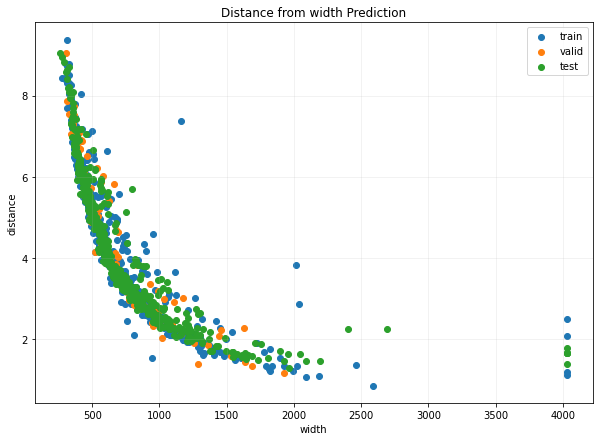

In [293]:
plt.figure(figsize=(10, 7))

plt.scatter(X_train.width, y_train, label='train') #добавим тренировочные данные
plt.scatter(X_test.width, y_test, label='valid') #добавим валидационные данные
plt.scatter(test_df['width'], test_df['distance'], label='test') #добавим тестовые данные

plt.title("Distance from width Prediction")
plt.ylabel('distance')
plt.xlabel('width')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

# Быстрый запуск

Загрузите библиотеки и установите модули

In [1]:
!pip install pyheif
!pip3 install exifread
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import os
from PIL import Image
from PIL.ExifTags import TAGS
import pyheif
import matplotlib.pyplot as plt
import io
import exifread

import torch
import numpy as np
import imutils
from tqdm import tqdm
from catboost import CatBoostRegressor

%matplotlib inline

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x')
model.classes = [2]  # car

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-26 Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


Укажите полный путь до папки, где лежат изображения.

In [4]:
test_path='/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/new_test_data'
test_img_names = os.listdir(test_path)

И выполните блок кода ниже.

In [12]:
# создание датафрейма с параметрами w, h, box для найденных на тестовых изображениях авто

def open_img(path, name):
  if 'heic' in name:
      heif_file = pyheif.read(os.path.join(path, name))
      img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
      img = Image.open(os.path.join(path, name))
  return img

# img -> [640,640]
def resize_img(path, img_name):
  img = open_img(path, img_name)
  #crop img to square
  width, height = img.size   # Get dimensions
  a = min(width, height)
  left = (width - a)/2
  top = (height - a)/2
  right = (width + a)/2
  bottom = (height + a)/2
  # Crop the center of the image
  small_img = img.crop((left, top, right, bottom))
  
  #modifies the image, no larger than the given size
  small_img.thumbnail((640, 640), Image.ANTIALIAS)
  return small_img, img

#выбор центрального авто с помощью Yolo
def find_central_car(small_img, original_img):
  #выберем 2 центральных авто
  def best_central_box(small_img, results, confidence):
    a, _ = small_img.size #width, height of squar, = 640
    c_dist = [] # расстояние между центром кадра и центром найденного авто    
    
    #loop for all cars in img
    for box in results.xyxy[0]:
      #print(box)
      # рассматриваем авто только если уверенность модели > confidence
      if box[4] > confidence:
        x1, y1, x2, y2 = np.array(box[:4]).astype(int)
        # сохраним расстояния от центра бокса авто до центра img 
        c_dist.append(abs((x1 + x2) * 0.5 - a / 2))

    # вернем индексы ближайших к центру авто
    sort_index = np.argsort(c_dist)
    
    #если не нашли, выходим из функции
    if len(sort_index) == 0:
      return [None, None, None, None]

    central_boxes = []
    x_c = []
    heights = []

    for i in range(len(sort_index)):
      #координаты авто
      central_boxes.append(np.array(results.xyxy[0][sort_index[i]][:4]).astype(int))
      x_c.append(c_dist[sort_index[i]]) # центр авто
      heights.append(central_boxes[i][3] - central_boxes[i][1])

    #если только 1 central_box, возвращаем его
    if len(sort_index) == 1:
      return central_boxes[0]
  
    #если нашли несколько boxes
    #рассмотрим 3
    #Если между ними и gервым авто небольшое расстояние, то берем то авто, высота которого больше
    for i in range(1, min(len(sort_index), 3)):
    #print('dist', abs(x_c[i] - x_c[i+1]))
      if abs(x_c[i] - x_c[0]) < 100: #150
        if (heights[i]) > (heights[0]):
          return central_boxes[i]
    #Если большое расстояние, то берем центральное авто
    return central_boxes[0]

  # найдем соответствие между координатами crop_image и original_image    
  def return_coordinates(original_img, a, x1, y1, x2, y2):
    w, h = original_img.size
    y1_original, y2_original, x1_original, x2_original = 0, h, 0, w
    #gorisontal oriented img
    if w > h:
      y1_original = int(y1 * h / a)
      y2_original = int(y2 * h / a)
      x1_original = int(x1 * h / a + (w - h) / 2)
      x2_original = int(x2 * h / a + (w - h) / 2)
    #vertical oriented img
    else:
      y1_original = int(y1 * h / a + (h - w) / 2)
      y2_original = int(y2 * h / a + (h - w) / 2)
      x1_original = int(x1 * h / a)
      x2_original = int(x2 * h / a)
    return [x1_original, y1_original, x2_original, y2_original]
  
  #apply yolo
  results = model(np.array(small_img))
  #выберем лучшее авто по центру, с уверенностью yolo > 5%
  x1, y1, x2, y2 = best_central_box(small_img, results, 0.05)
  
  #если не нашли, вернем центральную чась original_img
  if x1 == None:
    print('Car did not found')
    w, h = original_img.size
    return np.asarray(original_img), [0, 0, w, h]
  
  #перевод координат из small_img в original_img
  x1_original, y1_original, x2_original, y2_original = return_coordinates(original_img, small_img.size[0], x1, y1, x2, y2)
  
  #img2 = draw_object(original_img, x1_original, y1_original, x2_original, y2_original)
  #plt.imshow(img2)
  crop_img = np.array(original_img)[y1_original:y2_original, x1_original:x2_original]

  return crop_img, [x1_original, y1_original, x2_original, y2_original]

#создание датафрейма с данными о положении и линейных размерах авто
def find_car_test(path, img_names):
  width = {}
  height = {}
  car_box = {}
  for name in tqdm(img_names):
    small_img, original_img = resize_img(path, name)
    crop_img, box = find_central_car(small_img, original_img)
    width[name] = crop_img.shape[1]
    height[name] = crop_img.shape[0]
    car_box[name] = box
  width_df = pd.DataFrame.from_dict(width, orient='index', columns=['width']).reset_index().rename(columns={'index': 'image_name'})
  height_df = pd.DataFrame.from_dict(height, orient='index', columns=['height']).reset_index().rename(columns={'index': 'image_name'})
  car_box_df = pd.DataFrame.from_dict(car_box, orient='index', columns=['x1', 'y1', 'x2', 'y2']).reset_index().rename(columns={'index': 'image_name'})
  df = width_df.merge(height_df, on='image_name')
  df = df.merge(car_box_df, on='image_name')
  return df


#объединить dataframe c инфо о позиции авто и exif данные
def get_info_df(df):

  #вспомогательная ф-я для преобразования данных из DigitalZoomRatio
  def get_ratio(a):
    numbers = []
    if '/' in a:
      elements = str.split(a, sep='/')
    else:
      elements = str.split(a)
    for el in elements:
      number = str()
      for char in el:
        if char.isdigit():
          number += char
      numbers.append(int(number))
    if len(numbers) == 0:
      return 0
    if len(numbers) == 1:
      return numbers[0]
    if len(numbers) >= 2:
      return numbers[0] / numbers[1]
  
  def get_exif(img):
    exifdata = img.getexif()
    exif_info = []
    for tag_id in exifdata:
        data = exifdata.get(tag_id)
        exif_info.append(data)
    return exif_info

  def get_tags():
    img = open_img(test_path, df.image_name[0])
    exifdata = img.getexif()
    tags = []
    for tag_id in exifdata:
        # получить имя тега вместо идентификатора
        tag = TAGS.get(tag_id, tag_id)
        tags.append(tag)
    return tags

  def get_keys(name, tags):
    keys = []
    for key in tags.keys():
      keys.append(str(key))
    return keys

  def get_values(tags):
    values = []
    for value in tags.values():
      values.append(str(value))
    return values

  def get_heic_exif(heif_file):
    img_metadata = heif_file.metadata

    for metadata in img_metadata:
      if metadata['type']=='Exif':
          fstream = io.BytesIO(metadata['data'][6:])

    return exifread.process_file(fstream)

  exif_info = {} #jpg
  exif_heic_info = {} #heic
  keys = []

  # Получаем exif данные для всех изображений
  for name in tqdm(df.image_name):
    if 'heic' in name:
      heif_file = pyheif.read(os.path.join(test_path, name))
      tags = get_heic_exif(heif_file) #type dict
      if len(keys) < len(get_keys(name, tags)):
        keys = get_keys(name, tags)
      exif_heic_info[name] = get_values(tags)

    else: #jpg
      img = open_img(test_path, name)
      exif_info[name] = get_exif(img)

  # собираем их в датафреймы
  #если нет .heic файлов
  if exif_heic_info == {}:
    tags = get_tags()
    exif_info_df = pd.DataFrame.from_dict(exif_info, orient='index', columns=tags)
    # берем интересующие нас колонки
    info_df = exif_info_df['DigitalZoomRatio']
  
  else:
    exif_heic_info_df = pd.DataFrame.from_dict(exif_heic_info, orient='index', columns=keys)
    tags = get_tags()
    exif_info_df = pd.DataFrame.from_dict(exif_info, orient='index', columns=tags)

    # берем интересующие нас колонки
    exif_info_df = exif_info_df['DigitalZoomRatio']
    exif_heic_info_df = exif_heic_info_df['EXIF DigitalZoomRatio']
    exif_heic_info_df = exif_heic_info_df.rename('DigitalZoomRatio')
    
    # объединяем данный из heic и jpg
    info_df = pd.concat([exif_info_df, exif_heic_info_df], axis=0)

  #обработаем данные, чтобы получить числа
  for index in info_df.index:
    el = str(info_df[index])
    info_df.loc[index] = get_ratio(el)

  # Добавим к нифо о найденном авто, инфо об особенностях объектива из exif
  df = df.set_index('image_name')  
  df = pd.concat([df, info_df], axis = 1)

  return df

# предсказание модели для датафрейма с параметрами найденного авто
def prediction(model, df):
  X_pred = pd.concat([df.width,	df.height,	df.x1,	df.y1,	df.x2,	df.y2,	df.DigitalZoomRatio], axis=1)
  preds = model.predict(X_pred)
  df['distance'] = preds
  return df

test_df = find_car_test(test_path, test_img_names)
test_df = get_info_df(test_df)
test_df['image_name'] = test_df.index

100%|██████████| 9/9 [00:00<00:00, 347.70it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Скачайте обученную модель, указав путь до нее.

In [14]:
# load model
cat = CatBoostRegressor()
cat.load_model('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/catboost_model_good')

Укажите, куда будете сохранять результат предсказания модели.

In [15]:
test_df = prediction(cat, test_df)
test_df[['image_name', 'distance']].to_csv('/content/drive/MyDrive/Colab Notebooks/Count_distanse_to_the_car/Data/new_test_data/sample_solution_test.csv', sep = ';', index = False)

In [16]:
test_df

,width,height,x1,y1,x2,y2,DigitalZoomRatio,image_name,distance
img_1597.jpg,818,714,1557,1105,2375,1819,1.261051,img_1597.jpg,3.860584
img_1617.jpg,2693,2112,664,538,3357,2650,26,img_1617.jpg,2.788603
img_1611.jpg,401,396,1704,1323,2105,1719,1.238329,img_1611.jpg,7.494981
img_1610.jpg,336,345,1864,1261,2200,1606,1.238329,img_1610.jpg,8.341124
img_1609.jpg,420,264,2304,1271,2724,1535,1.305699,img_1609.jpg,7.986068
img_1604.jpg,2089,1819,933,987,3022,2806,1.261051,img_1604.jpg,1.707150
img_1602.jpg,1200,1063,1335,1115,2535,2178,1.261051,img_1602.jpg,2.957631
img_1599.jpg,1488,1209,1151,1044,2639,2253,1.261051,img_1599.jpg,2.187666
img_1598.jpg,1134,950,1392,1105,2526,2055,1.261051,img_1598.jpg,2.986693


Готово!